C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0105 - val_loss: 0.0056
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 7/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 8/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 9/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 10/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 11/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 12/100
145/145 ━━━━━━━━━

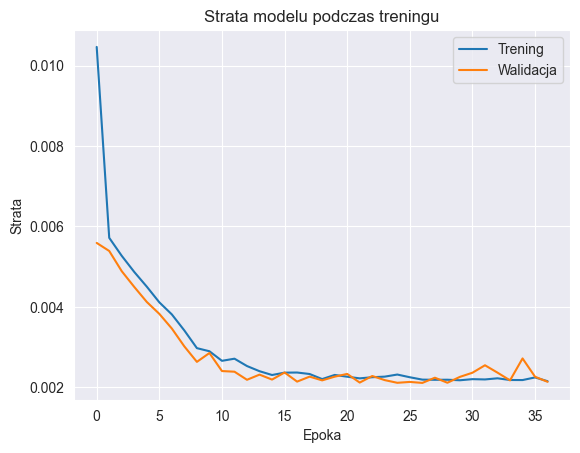

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


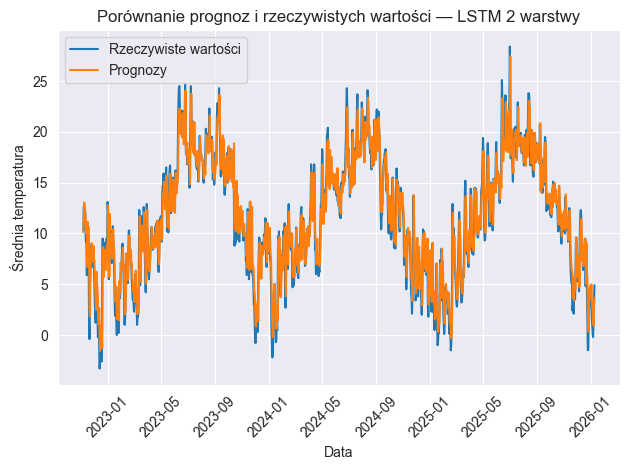

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# =========================
# Wczytanie i przygotowanie danych
# =========================
df = pd.read_csv(
    "european_capitals_history_clean.csv",
    parse_dates=["date"]
)

df_city = df[df['city'] == 'Warszawa']
df_city = df_city[['date', 'city', 'tavg']]
df_city.sort_values(by=["date"], inplace=True)

# =========================
# Tworzenie sekwencji czasowych
# =========================

def create_sequences(df, window=20):  # <- zmienione z 5 na 10
    sequences = []
    labels = []
    for i in range(len(df) - window):
        seq = df.iloc[i:i + window]['tavg'].values
        label = df.iloc[i + window]['tavg']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Tworzenie sekwencji z nowym window
sequences, labels = create_sequences(df_city, window=20)

# =========================
# Normalizacja danych
# =========================
scaler = MinMaxScaler()
sequences_scaled = scaler.fit_transform(sequences.reshape(-1, 1)).reshape(sequences.shape)
labels_scaled = scaler.transform(labels.reshape(-1, 1))
sequences_scaled = sequences_scaled.reshape((sequences_scaled.shape[0], sequences_scaled.shape[1], 1))

# =========================
# Podział na zbiór treningowy i testowy
# =========================
train_size = int(len(sequences_scaled) * 0.8)
X_train = sequences_scaled[:train_size]
X_test  = sequences_scaled[train_size:]
y_train = labels_scaled[:train_size]
y_test  = labels_scaled[train_size:]

# =========================
# Budowa modelu LSTM z dwiema warstwami
# =========================
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# =========================
# EarlyStopping
# =========================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# =========================
# Trenowanie modelu
# =========================
history = model.fit(
    X_train,
    y_train,
    epochs=100,           # można zwiększyć liczbę epok, EarlyStopping zatrzyma trening wcześniej
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# =========================
# Zapis modelu
# =========================
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "lstm_warszawa_2layers.keras")
model.save(model_path)
print(f"Model zapisany w: {model_path}")

# =========================
# Wizualizacja straty
# =========================
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.legend()
plt.title("Strata modelu podczas treningu")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.show()

# =========================
# Predykcja na zbiorze testowym
# =========================
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.plot(df_city['date'].iloc[-len(y_test_rescaled):], y_test_rescaled, label='Rzeczywiste wartości')
plt.plot(df_city['date'].iloc[-len(predictions_rescaled):], predictions_rescaled, label='Prognozy')
plt.legend()
plt.title("Porównanie prognoz i rzeczywistych wartości — LSTM 2 warstwy")
plt.xlabel("Data")
plt.ylabel("Średnia temperatura")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# =========================
# Funkcja budująca model LSTM z 2 warstwami i Dropout
# =========================
def build_lstm_model(input_shape):
    model = Sequential()
    # Pierwsza warstwa LSTM zwracająca sekwencję
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    # Druga warstwa LSTM zwracająca tylko ostatnią wartość
    model.add(LSTM(units=32, return_sequences=False))
    # Warstwa wyjściowa
    model.add(Dense(1))
    # Kompilacja
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# =========================
# Time Series Cross-Validation
# =========================
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
mae_scores  = []
mse_scores  = []
r2_scores   = []

fold = 1

for train_index, test_index in tscv.split(sequences_scaled):
    print(f"\nFold {fold}")

    X_train = sequences_scaled[train_index]
    X_test  = sequences_scaled[test_index]

    y_train = labels_scaled[train_index]
    y_test  = labels_scaled[test_index]

    model = build_lstm_model(input_shape=(X_train.shape[1], 1))

    # =========================
    # EarlyStopping
    # =========================
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model.fit(
        X_train,
        y_train,
        epochs=100,           # EarlyStopping zatrzyma trening wcześniej
        batch_size=32,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        shuffle=False
    )

    y_pred = model.predict(X_test)

    # Odwrócenie skalowania
    y_test_rescaled = scaler.inverse_transform(y_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    mse  = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2   = r2_score(y_test_rescaled, y_pred_rescaled)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(
        f"R²: {r2:.4f} | "
        f"MAE: {mae:.4f} | "
        f"MSE: {mse:.4f} | "
        f"RMSE: {rmse:.4f}"
    )

    fold += 1

# =========================
# Podsumowanie wyników
# =========================
print("\nWalk-Forward Cross-Validation — LSTM (2 warstwy + EarlyStopping)")
print(f"R²   : {np.mean(r2_scores):.4f}")
print(f"MAE  : {np.mean(mae_scores):.4f}")
print(f"MSE  : {np.mean(mse_scores):.4f}")
print(f"RMSE : {np.mean(rmse_scores):.4f}")



Fold 1


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
R²: 0.9008 | MAE: 1.4365 | MSE: 3.3750 | RMSE: 1.8371

Fold 2


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
R²: 0.9015 | MAE: 1.4219 | MSE: 3.3979 | RMSE: 1.8433

Fold 3


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
R²: 0.9026 | MAE: 1.5181 | MSE: 3.6746 | RMSE: 1.9169

Fold 4


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
R²: 0.8905 | MAE: 1.4118 | MSE: 3.4880 | RMSE: 1.8676

Fold 5


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
R²: 0.9020 | MAE: 1.4348 | MSE: 3.4555 | RMSE: 1.8589

Walk-Forward Cross-Validation — LSTM (2 warstwy + EarlyStopping)
R²   : 0.8995
MAE  : 1.4446
MSE  : 3.4782
RMSE : 1.8648


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


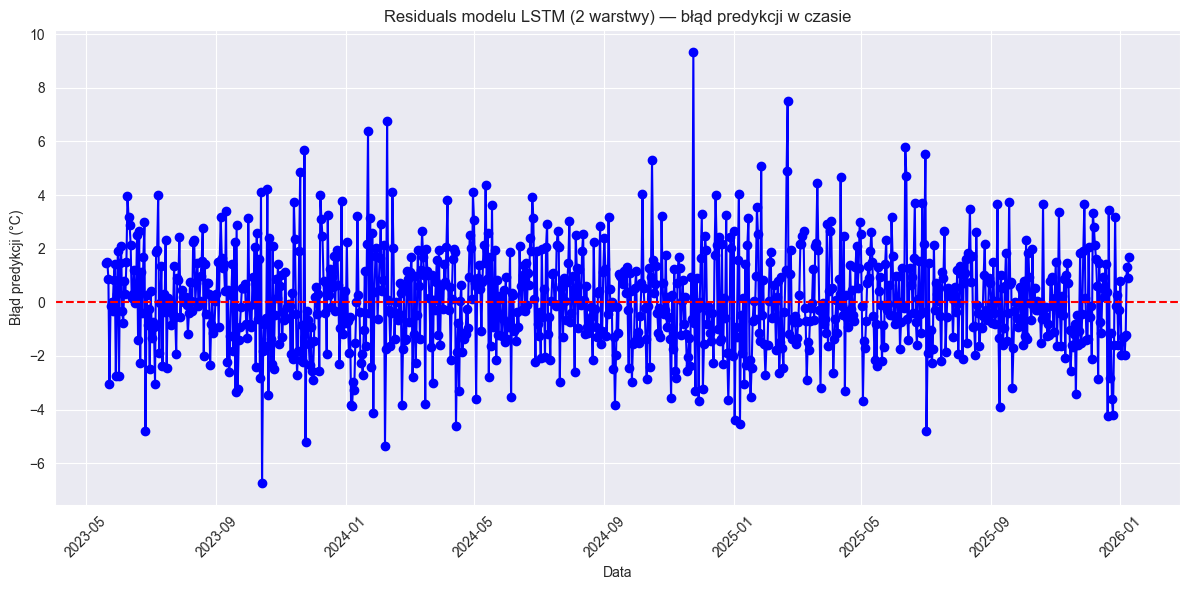

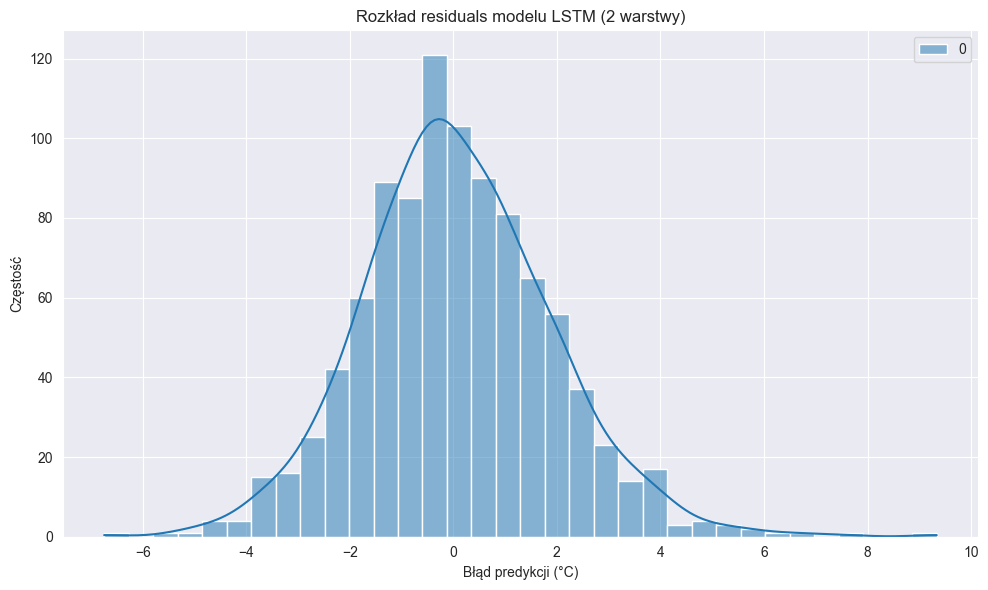

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# Predykcja na zbiorze testowym
# =========================
predictions = model.predict(X_test)

# Odwrócenie skalowania
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Dopasowanie długości (czasem w LSTM występuje różnica długości)
min_len = min(len(y_test_rescaled), len(predictions_rescaled))
y_test_rescaled = y_test_rescaled[:min_len]
predictions_rescaled = predictions_rescaled[:min_len]

# =========================
# Obliczenie residuals
# =========================
residuals = y_test_rescaled - predictions_rescaled

# =========================
# Wykres residuals w czasie
# =========================
plt.figure(figsize=(12,6))
plt.plot(
    df_city['date'].iloc[-len(residuals):],
    residuals,
    marker='o',
    linestyle='-',
    color='b'
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals modelu LSTM (2 warstwy) — błąd predykcji w czasie')
plt.xlabel('Data')
plt.ylabel('Błąd predykcji (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Histogram residuals
# =========================
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='b')
plt.title('Rozkład residuals modelu LSTM (2 warstwy)')
plt.xlabel('Błąd predykcji (°C)')
plt.ylabel('Częstość')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/100


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0208 - val_loss: 0.0069
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 9/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 10/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 11/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 12/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

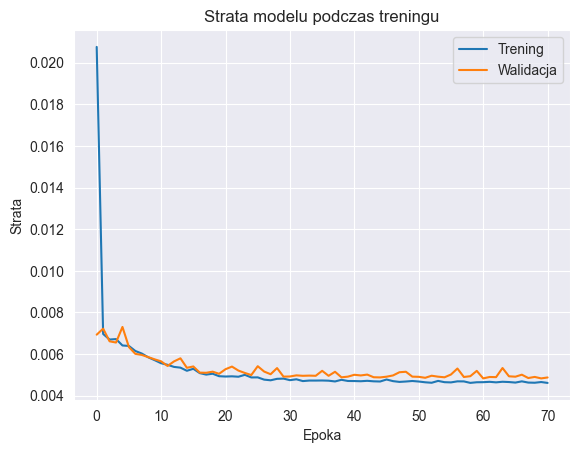

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


ValueError: x and y must have same first dimension, but have shapes (1166,) and (5830,)

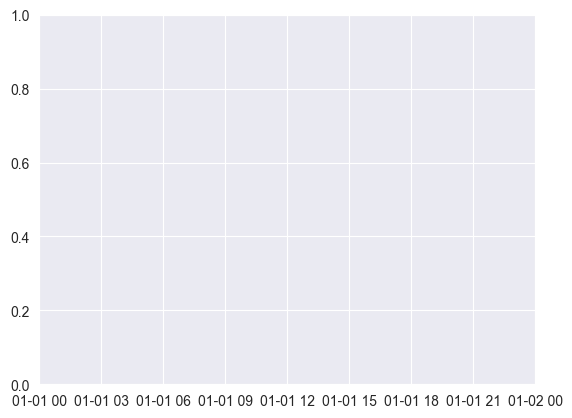

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
df = pd.read_csv("european_capitals_history_clean.csv", parse_dates=["date"])
df_city = df[df['city'] == 'Warszawa'][['date', 'tavg']]
df_city.sort_values(by="date", inplace=True)

# =========================
# 2. Tworzenie sekwencji z multi-step output
# =========================
def create_sequences(df, window=20, forecast_horizon=5):
    X, y = [], []
    for i in range(len(df) - window - forecast_horizon + 1):
        X.append(df.iloc[i:i+window]['tavg'].values)
        y.append(df.iloc[i+window:i+window+forecast_horizon]['tavg'].values)  # multi-step
    return np.array(X), np.array(y)

WINDOW = 20
FORECAST = 5
X, y = create_sequences(df_city, WINDOW, FORECAST)

# =========================
# 3. Normalizacja danych
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1,1)).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

# LSTM wymaga [samples, timesteps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# =========================
# 4. Podział na zbiór treningowy i testowy
# =========================
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# =========================
# 5. Budowa modelu LSTM 2-warstwowego
# =========================
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(FORECAST))  # multi-step output
model.compile(optimizer='adam', loss='mean_squared_error')

# =========================
# 6. EarlyStopping
# =========================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# =========================
# 7. Trenowanie modelu
# =========================
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# =========================
# 8. Zapis modelu
# =========================
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "lstm_warszawa_5days.keras")
model.save(model_path)
print(f"Model zapisany w: {model_path}")

# =========================
# 9. Wizualizacja straty
# =========================
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.legend()
plt.title("Strata modelu podczas treningu")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.show()

# =========================
# 10. Predykcja na zbiorze testowym
# =========================
predictions_scaled = model.predict(X_test)
predictions_rescaled = scaler_y.inverse_transform(predictions_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test)

plt.plot(df_city['date'].iloc[-len(y_test_rescaled):], y_test_rescaled.flatten(), label='Rzeczywiste wartości')
plt.plot(df_city['date'].iloc[-len(predictions_rescaled):], predictions_rescaled.flatten(), label='Prognozy')
plt.legend()
plt.title("Porównanie prognoz i rzeczywistych wartości — LSTM 2 warstwy")
plt.xlabel("Data")
plt.ylabel("Średnia temperatura")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 11. Prognoza na 5 dni w przyszłość (ostatnia sekwencja z testu)
# =========================
future_scaled = model.predict(X_test[-1].reshape(1, WINDOW, 1))
future_pred = scaler_y.inverse_transform(future_scaled)

print("Prognozy na 5 dni do przodu (średnia temperatura):")
print(future_pred.flatten())
